In [1]:
import os
from collections import Counter
from statistics import median

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import nltk
from nltk import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

from datasets import Dataset
import evaluate

print(f'Pytorch version: {torch.__version__}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')

RANDOM_SEED = 42
MAX_TOKENS = 16384

/home/dhairya/projects/sih/ml_components/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/dhairya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-09-18 20:37:39.517008: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 20:37:39.560660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the 

Pytorch version: 2.0.1+cu117
Device: NVIDIA GeForce MX350


In [2]:
data = pd.read_csv('../data/ILDC_single/ILDC_single.csv/ILDC_single.csv')
data.head()

,text,label,split,name
0,"F. NARIMAN, J. Leave granted. In 2008, the Pu...",1,train,2019_890.txt
1,"S. THAKUR, J. Leave granted. These appeals ar...",0,train,2014_170.txt
2,"Markandey Katju, J. Leave granted. Heard lear...",1,train,2010_721.txt
3,"ALTAMAS KABIR,J. Leave granted. The question ...",1,train,2008_1460.txt
4,"CIVIL APPEAL NO. 598 OF 2007 K. MATHUR, J. Th...",1,train,2008_188.txt


In [3]:
# data split percentages
data_s = Counter(data['split'])
num_rows = sum(data_s.values())
[float(f'{val/num_rows:.2f}') for val in data_s.values()]

[0.67, 0.2, 0.13]

In [4]:
train_ds = data[data['split'] == 'train'].drop(['split', 'name'], axis=1)
dev_ds = data[data['split'] == 'dev'].drop(['split', 'name'], axis=1)
test_ds = data[data['split'] == 'test'].drop(['split', 'name'], axis=1)

In [5]:
x = train_ds.loc[:, 'text']
lens = ([len(k) for k in x])
int(sum(lens)/len(lens)), max(lens), min(lens), int(median(lens))

(23650, 521891, 880, 17529)

In [6]:
print(Counter(train_ds['label']))
print(Counter(dev_ds['label']))
print(Counter(test_ds['label']))

Counter({0: 3147, 1: 1935})
Counter({0: 497, 1: 497})
Counter({1: 762, 0: 755})


In [7]:
# convert pd to hugging face datsets
hg_train_ds = Dataset.from_pandas(train_ds)
hg_dev_ds = Dataset.from_pandas(dev_ds)

hg_train_ds, hg_dev_ds

(Dataset({
     features: ['text', 'label', '__index_level_0__'],
     num_rows: 5082
 }),
 Dataset({
     features: ['text', 'label', '__index_level_0__'],
     num_rows: 994
 }))

In [8]:
tokenizer = AutoTokenizer.from_pretrained('hyperonym/xlm-roberta-longformer-base-16384')

In [9]:
print(f'Unknown token: {tokenizer.unk_token}, ID: {tokenizer.unk_token_id}')
print(f'Seperator token: {tokenizer.sep_token}, ID: {tokenizer.sep_token_id}')
print(f'Padding token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}')
print(f'mask token: {tokenizer.mask_token}, ID: {tokenizer.mask_token_id}')
print(f'Sentence level classification token: {tokenizer.cls_token}, ID: {tokenizer.cls_token_id}')

Unknown token: <unk>, ID: 3
Seperator token: </s>, ID: 2
Padding token: <pad>, ID: 1
mask token: <mask>, ID: 250001
Sentence level classification token: <s>, ID: 0


In [10]:
import string

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

def preprocess_text(data: Dataset):
    text: str = data['text'].strip()
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = lemmatizer.lemmatize(text, 'v')
    text = porter.stem(text)

    return text

In [11]:
def tokenize_ds(data: Dataset):
    text = preprocess_text(data)
    tokenized_ds = {
        'input_ids': tokenizer.encode(
            text, padding='max_length', max_length=MAX_TOKENS, return_tensors="pt"
    )}
    return tokenized_ds

In [12]:
tokenized_train_a = hg_train_ds.map(tokenize_ds)
tokenized_dev_a = hg_dev_ds.map(tokenize_ds)

Map: 100%|██████████| 994/994 [00:22<00:00, 43.78 examples/s]


In [13]:
tokenized_train_a, tokenized_dev_a

(Dataset({
     features: ['text', 'label', '__index_level_0__', 'input_ids'],
     num_rows: 5082
 }),
 Dataset({
     features: ['text', 'label', '__index_level_0__', 'input_ids'],
     num_rows: 994
 }))

In [14]:
inp_ids = tokenized_train_a[:]['input_ids'][:]
tkn_lens = [len(ids[0]) for ids in inp_ids]
print(median(tkn_lens))

print(Counter([(tkn <= MAX_TOKENS) for tkn in tkn_lens]))

16384.0
Counter({True: 4943, False: 139})


In [15]:
inp_idsd = tokenized_dev_a[:]['input_ids'][:]
tkn_lensd = [len(ids[0]) for ids in inp_idsd]
print(median(tkn_lensd))

print(Counter([(tkn <= MAX_TOKENS) for tkn in tkn_lensd]))

16384.0
Counter({True: 971, False: 23})


[]

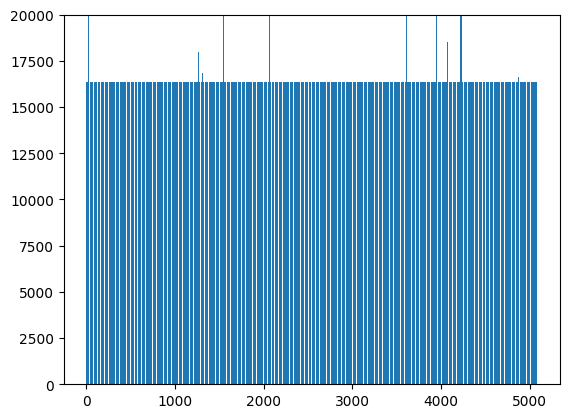

In [16]:
plt.bar(np.arange(len(tkn_lens)), tkn_lens)
plt.ylim([0, 20_000])
plt.plot()

In [17]:
def filter_func(datapoint):
    return len(datapoint['input_ids'][0]) <= MAX_TOKENS

filtered_train = tokenized_train_a.filter(filter_func)
filtered_dev = tokenized_dev_a.filter(filter_func)

Filter: 100%|██████████| 994/994 [00:06<00:00, 154.48 examples/s]


In [18]:
print(Counter(filtered_train['label']))
print(Counter(filtered_dev['label']))

Counter({0: 3055, 1: 1888})
Counter({1: 489, 0: 482})


In [19]:
filtered_train, filtered_dev

(Dataset({
     features: ['text', 'label', '__index_level_0__', 'input_ids'],
     num_rows: 4943
 }),
 Dataset({
     features: ['text', 'label', '__index_level_0__', 'input_ids'],
     num_rows: 971
 }))

In [20]:
rm_cols = ('text', '__index_level_0__', 'label')
tokenized_train = filtered_train.remove_columns(rm_cols)
tokenized_dev = filtered_train.remove_columns(rm_cols)

In [21]:
tokenized_train, tokenized_dev

(Dataset({
     features: ['input_ids'],
     num_rows: 4943
 }),
 Dataset({
     features: ['input_ids'],
     num_rows: 4943
 }))

In [22]:
k = tokenized_train[:]['input_ids']

print(len(k))
tkn_lensk = [len(ids[0]) for ids in k]
print(median(tkn_lensk))

print(Counter([(tkn == MAX_TOKENS) for tkn in tkn_lensk]))

4943
16384
Counter({True: 4943})


In [23]:
inp_idsd = tokenized_dev_a[:]['input_ids'][:]
tkn_lensd = [len(ids[0]) for ids in inp_idsd]
print(median(tkn_lensd))

print(Counter([(tkn <= MAX_TOKENS) for tkn in tkn_lensd]))

16384.0
Counter({True: 971, False: 23})


In [24]:
# # remname label to labels as pytorch expects it
# tokenized_train = tokenized_train.rename_column('label', 'labels')
# tokenized_dev = tokenized_dev.rename_column('label', 'labels')

In [25]:
# change format
tokenized_train.set_format('torch')
tokenized_dev.set_format('torch')

In [26]:
tokenized_train[0]

{'input_ids': tensor([[   0, 1238,   24,  ...,    1,    1,    1]])}

In [27]:
if device == 'cuda': torch.cuda.empty_cache()

BATCH_SIZE = 4

train_dl = DataLoader(dataset=tokenized_train, shuffle=True, batch_size=BATCH_SIZE)
dev_dl = DataLoader(dataset=tokenized_dev, shuffle=False, batch_size=BATCH_SIZE)

In [28]:
EPOCHS = 2
TRAIN_STEPS = num_rows * len(train_dl)

In [31]:
if device == 'cuda': torch.cuda.empty_cache()

In [32]:
# model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('hyperonym/xlm-roberta-longformer-base-16384', from_tf=True, num_labels=2)

2023-09-18 20:46:30.092210: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 732.43MiB (rounded to 768006144)requested by op StatelessTruncatedNormalV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-09-18 20:46:30.092287: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-09-18 20:46:30.092306: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 50, Chunks in use: 50. 12.5KiB allocated for chunks. 12.5KiB in use in bin. 1.9KiB client-requested in use in bin.
2023-09-18 20:46:30.092319: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 512B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-09-18 20:46:30.092332: I tensorflow/tsl/fram

ResourceExhaustedError: Exception encountered when calling layer 'longformer' (type TFLongformerMainLayer).

{{function_node __wrapped__StatelessTruncatedNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[250002,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessTruncatedNormalV2] name: 

Call arguments received by layer 'longformer' (type TFLongformerMainLayer):
  • input_ids=tf.Tensor(shape=(1, 2), dtype=int64)
  • attention_mask=tf.Tensor(shape=(1, 2), dtype=int64)
  • head_mask=None
  • global_attention_mask=tf.Tensor(shape=(1, 2), dtype=int64)
  • token_type_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • position_ids=None
  • inputs_embeds=None
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=5e-6)

lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

model.to(device)

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps

In [ ]:
def train_model(train_dataloader, 
                epochs, 
                train_steps, 
                optimizer, 
                lr_scheduler):

    progress_bar = tqdm(range(train_steps))
    losses = []

    model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            # get batch data
            batch = {k: v.to(device) for k, v in batch.items()}
            # print(batch)

            # get model output
            outputs = model(**batch)

            # get loss and backprop
            loss = outputs.loss
            losses.append(loss)

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            # clear gradients
            optimizer.zero_grad()

            # update progress
            progress_bar.update(1) 

In [ ]:
train_model(train_dl,
            EPOCHS,
            TRAIN_STEPS,
            optimizer,
            lr_scheduler)

  0%|          | 0/1184508 [00:00<?, ?it/s]

{'input_ids': tensor([[[    0, 37635, 28500,  ...,     1,     1,     1]],

        [[    0, 34928, 28500,  ...,     1,     1,     1]],

        [[    0, 37635, 28500,  ...,     1,     1,     1]],

        ...,

        [[    0, 37635, 28500,  ...,     1,     1,     1]],

        [[    0, 37635, 28500,  ...,     1,     1,     1]],

        [[    0, 37635, 28500,  ...,     1,     1,     1]]], device='cuda:0')}


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 1.95 GiB total capacity; 543.10 MiB already allocated; 1.32 GiB free; 590.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF